# Intro to TF 101

## What is Tensorflow?


 > TensorFlow is an open-source machine learning framework used in data science and artificial intelligence. It represents data as tensors and operates on them through a computational graph. It's popular for deep learning, offering high-level APIs for neural networks. TensorFlow is flexible, scalable, and has a supportive community, making it a vital tool for master's students in machine learning and data science.

 _Cit: ChatGPT_

## What actually is Tensorflow?

It can be your best friend or your worst nightmare, depending on which background you have, and what platform you're using (but we luckly have Colab <3)

Tensorflow (from now on TF) is "mainly" a Numpy+"differentiation library" (it actually can do [muuuuch more than that](https://www.tensorflow.org/resources/libraries-extensions) but we don't care about it for the moment)... it has a little sister called Keras, which is nothing more that a set of tools that (hopefully) work out-of-the-box for DeepLearning

However, don't think that TF/Keras are just for DeepLearning... TF is used for any kind of (gradient) optimization, as we will see

## How to use it

Well, the first thing to do, it's definitely to check if Colab set this notebook to run on GPU, or tomorrow we might still be here waiting...

### Intro

Well importing it might be a nice starting step (and recall to rename it, a must, same for his little brother numpy)

In [1]:
import tensorflow as tf
import numpy as np

TF has many functionalities, that you can find in [the documentation](https://www.tensorflow.org/api_docs/python/tf), functionalities that encodes some sort of computations (data manipulation, activation functions, tensor manipulation and so on)

![](https://pbs.twimg.com/media/E10ffa9X0AA4H2_.png)

### Tensors


However, everything requires some sort of tensors (n-dimensional arrays), and there are a handful of versions that you might want to keep in mind.

In [2]:
# Constants, aka you can't change their value
# They can be scalars
your_constant = tf.constant(10)
# Or arrays
your_constant = tf.constant([10, 11])

In [3]:
# Tensors, which you can instead manipulate
your_tensor = tf.convert_to_tensor([10, 11])

However, both of them have a very specific requirements, which is that whatever is inside, has to share the same type, and the whole framework is type-checked, so a int-tensor cannot be multiplied by a float tensor.

**PSA:** TF will try to deduce the type from whatever you are passing, so be very careful

In [4]:
# tf.constant(10) * tf.constant(11.)

In [5]:
tf.constant(10.) * tf.constant(11.)

<tf.Tensor: shape=(), dtype=float32, numpy=110.0>

You can enforce the type you want by using the `dtype` argument (present in almost all the functions of TF)

In [6]:
tf.constant(10, dtype=tf.float32) * tf.constant(11.)

<tf.Tensor: shape=(), dtype=float32, numpy=110.0>

or, you can cast it using `tf.cast`

In [7]:
tf.cast(tf.constant(10), dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

(everything is valid also for the tensors)

**PSA:** TF is very numpy friendly (they can go back and forth from np arrays to TF arrays), however, there is a very inconvenient scenario in both directions:  
 1. TF to np: you loose the gradient information (from the conversion on, tf will not register any operation and thus the gradient, we will see later what this means)
 2. np to TF: the casts tend to be using `float64`, where everything related to Deep Learning works in `float32` (yes, they are 2 different types)

In [8]:
tf.convert_to_tensor(np.array(10.))

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

Finally, if you add some computer science boilerplate wrapper around the `Tensor` class, you get the `Variable` class, which makes the TF life a bit easier in some cases (graph computation, will see it later)

![](https://i.redd.it/gpp8gmh0on861.jpg)

### Functions

TF provides a ton of functionalities, and it's useless list here all possible ones, however feel free to use ChatGPT if you need to find a function that does a certain computation, in my experience it knows TF pretty well when dealing with limited situations (don't ask to code everything in one go for you, it won't work most likely)

Heres the most useful ones:  
 1. `tf.nn` contains everything you can think that might be useful for neural networks
 2. `tf.keras` contains the Keras API
 3. `tf.optimizers` gradient optimizers
 4. `tf.random` everything dealing with randomness and sampling
 5. `tf.math` everything dealing with math functions

### Gradient

Gradients are a big part of Tensorflow, as it was born as an _automatic differentiation_ framework (God thanks for the chain-rule)

You can pretty much do anything gradient-related with `tf.GradientTape` (there are other ways, but personally I find this one the most elastic and clear one)

You can think `tf.GradientTape` as the BigBrother watching everything is happening under him (TF doesn't like privacy), and registering every step: if all such steps are performed with differentiable TF operations, he will apply the chain rule few millions times and hand you the gradient

In [9]:
# 1 - you create a variable:
v = tf.Variable(0.)

def f(x):
  return 2 * x
# 2 - you create the BigBrother
with tf.GradientTape() as tape:
  # 3 - you let the BigBrother spy on you
  y = f(v)

# 4 - you use the fruits of your privacy violation
tape.gradient(y, v) # dy / dv = df(x) / dx

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

However, TF always had the advantage over other frameworks to handle graph execution (they are catching up) over eager execution, heres a quick intro:
 1. eager execution: the one you always knew, it goes line by line and executes stuff on the fly
 2. graph execution: TF first checkes the operation graph of a function, sees if it can optimize it, and if so, simplifies/parallelize it (you have little power over what happens behind the scenes, but most of the times works just fine)  


 The whole point is that if in that function everything that happens is deterministing and never changes, it can create shorcuts (just like a compiler would do with your code), and make it faster for your GPU

In [10]:
# the @ notation is for _decorators_ in python (for the sake of the tutorial, you can consider it black magic)
@tf.function
def much_faster_function(v):
  return 2*v

v = tf.Variable(0.)
with tf.GradientTape() as tape:
  res = much_faster_function(v)

tape.gradient(res, v)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

## Let's start doing interesting stuff

If you got everything to this point, you are pretty much able to code anything in the DeepLearning community, well done

![](https://media.tenor.com/JHZWHc6hZgoAAAAC/thumbs-up-kid.gif)

As for all respected optimization tutorials, why not starting from our favourite model implementing it together...

linear regression :-)

### Simplified 101 linear regression - aka estimate the average

Since I wanted to give you a simple example of what the whole code should look like, and i couldn't come up with a nice example, heres the code to calculate the average of a bunch of points, by minimizing the mean squared error:
$$
L(\theta) = \frac{1}{N}\sum_{i=0}^N (i - mean)^2
$$

In [11]:
# defining variables
# in our case, we only need one varaible, that will represent the mean, and we will call it _average_
average = tf.Variable(0.)

# generaeting data
# we just generate some data, not really important for the sake of the example
data = tf.random.normal(shape=(100,), mean=10.)

# Optimizer (aka, please take the gradient and do a step in the opposite direction)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-1)

for i in range(100):
  with tf.GradientTape() as tape:
    # we can use tf.reduce_mean to take a N-dimensional tensor and get the average of it
    loss = tf.reduce_mean((data - average)**2)

  gradient = tape.gradient(loss, average) # this calculates the gradient dL / daverage
  optimizer.apply_gradients(zip([gradient], [average])) # applies the gradient, aka, does a step of gradient descent

  if i%10 == 0:
    print(f"average is {average.numpy()}, loss is {loss.numpy()}")

print(f"estimated average is {average.numpy()} but actual average is {tf.reduce_mean(data).numpy()}")

average is 0.09999997913837433, loss is 99.42302703857422
average is 1.0953370332717896, loss is 80.64661407470703
average is 2.0689616203308105, loss is 64.17123413085938
average is 3.0036797523498535, loss is 50.125335693359375
average is 3.886172294616699, loss is 38.46656799316406
average is 4.707355499267578, loss is 29.022966384887695
average is 5.461648464202881, loss is 21.547040939331055
average is 6.146078109741211, loss is 15.75981330871582
average is 6.759637355804443, loss is 11.379878044128418
average is 7.3029046058654785, loss is 8.141114234924316
estimated average is 7.73332405090332 but actual average is 9.91968059539795


As you can see, the loss goes down, and the mean moves towards the actual mean

Are optimizers just black magic? NO, they are just wrappers to very non-readable mathematical gibberish that applies the gradient to your varaibles, keeping track of extra informations (for adaptive settings or momentum)

We can definitely live without them if we prefer:

In [12]:
# defining variables
# in our case, we only need one varaible, that will represent the mean, and we will call it _average_
average = tf.Variable(0.)

data = tf.random.normal(shape=(100,), mean=10.)

for i in range(100):
  with tf.GradientTape() as tape:
    # we can use tf.reduce_mean to take a N-dimensional tensor and get the average of it
    loss = tf.reduce_mean((data - average)**2) ### TO COMPLETE ###

  gradient = tape.gradient(loss, average) # this calculates the gradient dL / daverage
  average.assign(average - 0.01 * gradient) # w = w - alpha * gradient

  if i%10 == 0:
    print(f"average is {average.numpy()}, loss is {loss.numpy()}")

print(f"estimated average is {average.numpy()} but actual average is {tf.reduce_mean(data).numpy()}")

average is 0.19858162105083466, loss is 99.52355194091797
average is 1.9785547256469727, loss is 66.75413513183594
average is 3.43292236328125, loss is 44.877010345458984
average is 4.621246337890625, loss is 30.27166748046875
average is 5.592194557189941, loss is 20.521015167236328
average is 6.385529518127441, loss is 14.011407852172852
average is 7.033741474151611, loss is 9.665543556213379
average is 7.56337833404541, loss is 6.764207363128662
average is 7.996130466461182, loss is 4.827249526977539
average is 8.349719047546387, loss is 3.5341298580169678
estimated average is 8.612292289733887 but actual average is 9.929081916809082


### Your turn, time for linear regression

Well, first, maybe it's better to create a dataset... since we don't like naive stuff, let's say that we can create a synthetic dataset where:
$$
x \sim U(0.5, 5.0),\,\,\, \text{(say 100 samples)}\\
y = log(x) + \epsilon, \,\,\, \epsilon \sim N(0, 0.05)\\
L(\theta) = \sum_{x,y}\left[(wx+b) - y\right]^2
$$

In [13]:
x = tf.random.uniform(shape=(100,), minval=0.5, maxval=5.0)
y = tf.math.log(x) + tf.random.normal(shape=(100,), mean=0, stddev=0.05)

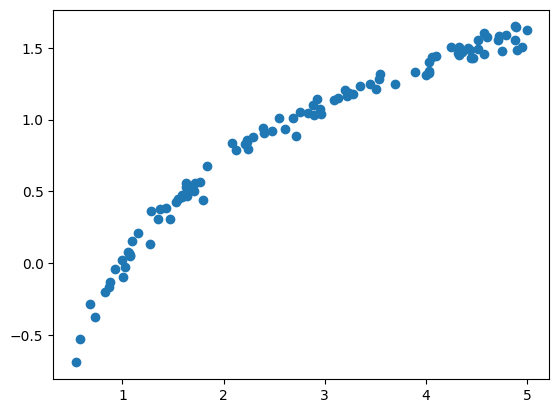

In [14]:
import matplotlib.pyplot as plt
plt.scatter(x, y)

Looks good to me, now let's try to fit a linear model on it with TF:
$$
y = wx+b
$$

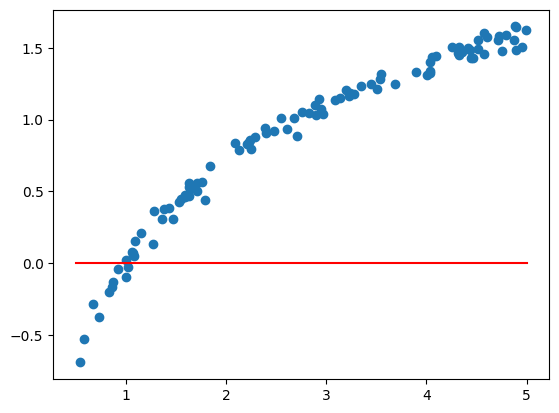

In [15]:
# well, we have one covariate, so we need only one variable
w = tf.Variable(0.)
# and our little friend bias
b = tf.Variable(0.)
# and we will need an optimizer
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def predict(x):
  return w*x+b

plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")

In [16]:
def loss(predictions, targets):
  return tf.reduce_mean((targets - predictions)**2)

for i in range(200):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 1.1093193292617798
epoch 10 - loss: 0.4650816023349762
epoch 20 - loss: 0.15576303005218506
epoch 30 - loss: 0.08117225766181946
epoch 40 - loss: 0.08317406475543976
epoch 50 - loss: 0.0790661945939064
epoch 60 - loss: 0.07023756206035614
epoch 70 - loss: 0.06541711837053299
epoch 80 - loss: 0.061858102679252625
epoch 90 - loss: 0.058068688958883286
epoch 100 - loss: 0.05456538125872612
epoch 110 - loss: 0.05135522782802582
epoch 120 - loss: 0.04836208373308182
epoch 130 - loss: 0.04561925306916237
epoch 140 - loss: 0.04312653839588165
epoch 150 - loss: 0.040876854211091995
epoch 160 - loss: 0.038863882422447205
epoch 170 - loss: 0.03707590699195862
epoch 180 - loss: 0.0354992114007473
epoch 190 - loss: 0.03411848470568657


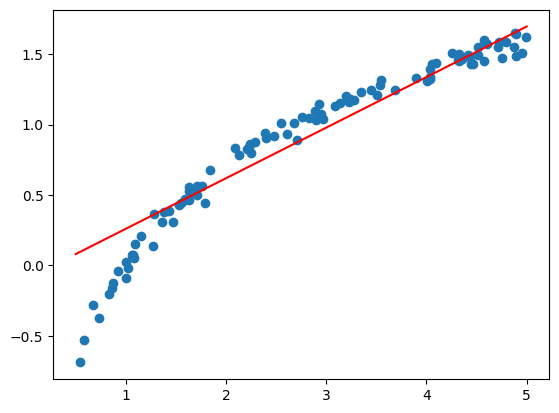

In [17]:
plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")

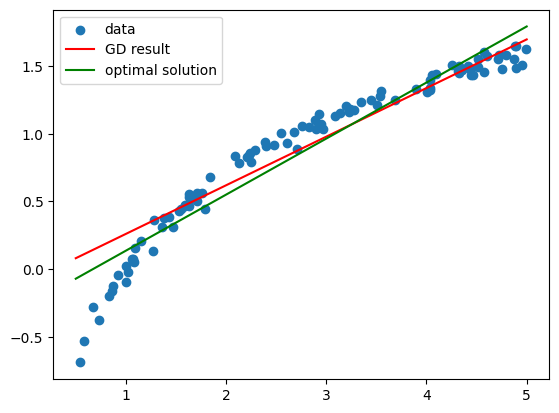

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x[..., None], y)
plt.scatter(x, y)
plt.plot([0.5, 5.0], [predict(0.5), predict(5.0)], c="red")
plt.plot([0.5, 5.0], [reg.predict([[0.5]]), reg.predict([[5.0]])], c="green")
plt.legend(["data", "GD result", "optimal solution"])

However, you are engineers, and you would do some more analysis on the model and see that the residuals are kinda bad, and so you would try to alter the data to improve it, right?

Text(0, 0.5, 'residual')

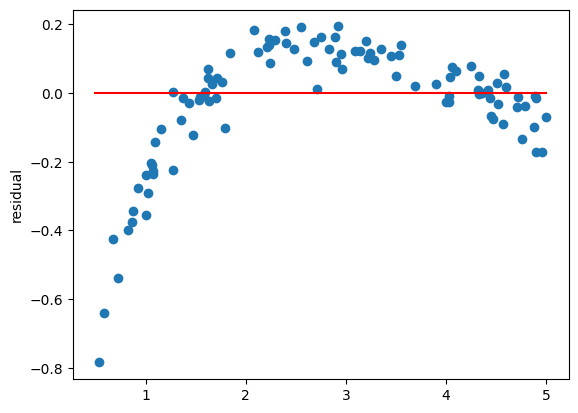

In [19]:
plt.scatter(x, y - predict(x))
plt.plot([0.5, 5.0], [0,0], c="red")
plt.ylabel("residual")

well, that's easy in our model, since we only need to redefine how to predict the target

In [20]:
w = tf.Variable(0.)
b = tf.Variable(0.)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.reduce_mean((predictions - targets)**2)

def predict(x):
  return w*tf.math.log(x)+b

for i in range(400):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 1.1093193292617798
epoch 10 - loss: 0.7544738054275513
epoch 20 - loss: 0.48595643043518066
epoch 30 - loss: 0.301778107881546
epoch 40 - loss: 0.18880055844783783
epoch 50 - loss: 0.12731914222240448
epoch 60 - loss: 0.09729296714067459
epoch 70 - loss: 0.08312365412712097
epoch 80 - loss: 0.075311578810215
epoch 90 - loss: 0.06940612196922302
epoch 100 - loss: 0.06391513347625732
epoch 110 - loss: 0.05857780575752258
epoch 120 - loss: 0.05344938114285469
epoch 130 - loss: 0.048590775579214096
epoch 140 - loss: 0.04402622580528259
epoch 150 - loss: 0.03976280987262726
epoch 160 - loss: 0.035803020000457764
epoch 170 - loss: 0.03214658051729202
epoch 180 - loss: 0.028789622709155083
epoch 190 - loss: 0.02572447620332241
epoch 200 - loss: 0.022940387949347496
epoch 210 - loss: 0.020424284040927887
epoch 220 - loss: 0.018161417916417122
epoch 230 - loss: 0.016135893762111664
epoch 240 - loss: 0.014331129379570484
epoch 250 - loss: 0.012730271555483341
epoch 260 - loss: 0.

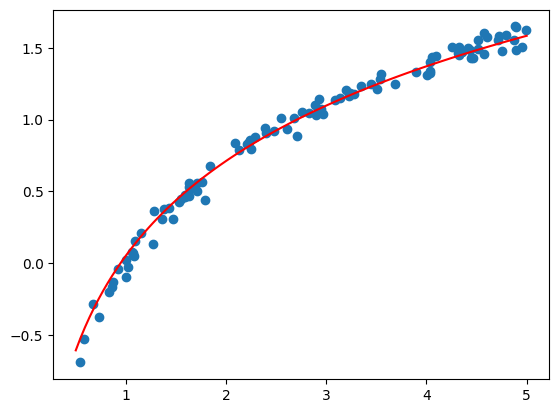

In [21]:
plt.scatter(x, y)
points = np.linspace(0.5, 5.0, 100)
plt.plot(points, predict(tf.cast(points, tf.float32)), c="red")

Say we want to use mean absolute error as loss and not mean squared error, we just need to change it in the code, and TF will handle the rest

In [22]:
w = tf.Variable(0.)
b = tf.Variable(0.)
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.math.abs(targets- predictions)

def predict(x):
  return w*tf.math.log(x)+b

for i in range(400):
  with tf.GradientTape() as tape:
    l = loss(predict(x), y)

  grad = tape.gradient(l, [w,b])
  optimizer.apply_gradients(zip(grad, [w,b]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: [1.3398824  0.5294635  0.8339164  0.6900206  1.0321149  0.07613091
 1.4390244  1.1817346  1.3151292  1.5524954  0.42879415 0.82839006
 1.3274633  1.5076932  0.02061016 0.06000131 0.5554328  1.5530943
 0.09228305 0.2010246  0.31033346 1.5715995  1.2315941  1.1452821
 1.0541496  0.87803364 0.37459618 1.4336443  0.56526846 0.38567394
 0.52978057 0.36379948 0.04285909 0.93872833 1.5845475  0.44371802
 0.02231414 0.46378905 0.7947442  1.2101023  1.4311534  1.5071888
 0.67842597 1.1502919  0.44613793 0.05366787 0.5232005  1.5853624
 1.4683261  1.0086547  1.0997615  0.90814435 1.4748504  0.0731449
 1.1332849  1.248409   1.6252401  1.247209   0.30766952 1.5533093
 0.49973103 0.8883201  0.9197991  1.3244013  0.13489658 1.0367348
 1.6014841  0.47402027 1.2027694  0.1523208  0.78497374 1.4820081
 1.4871482  1.6449955  1.07513    1.0117638  1.4971849  1.1745502
 1.4517825  0.16357239 0.8608894  1.6476307  0.20917061 1.2812504
 0.84130687 1.1606201  1.4925053  0.46551985 0.9331311  

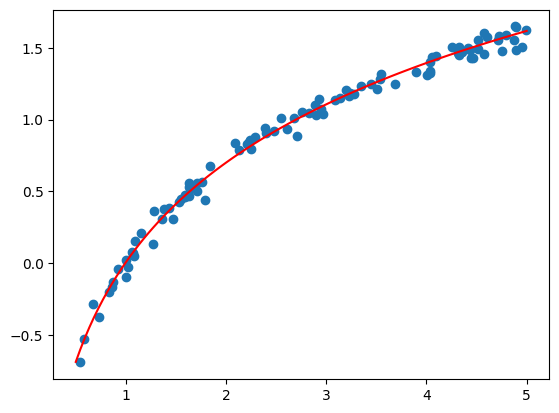

In [23]:
plt.scatter(x, y)
points = np.linspace(0.5, 5.0, 100)
plt.plot(points, predict(tf.cast(points, tf.float32)), c="red")

![](https://media.tenor.com/J5A9wZzn3ZYAAAAC/robert-redford-jeremiah-johnson.gif)

### Even PCA?

Well, we won't really implement PCA, that has some constraint on the definition of the matrixes, but at the end of the day, is purely a linear transformation of the data, and it has been proven that any linear transformation of it will lead to the same solution or to an equivalent one (same loss)

so, what we need is to minimize the following:
$$
L(\theta) = \sum_x (W^T(Wx) - x)^2
$$
Thus, we first project $x$ to a lower dimensional space via $W$, and via $W^$ we project it back to the original one, and we hope that such projection-back reconstruct $x$ as good as possible (for simplicity, we assume that the mean is 0, so we don't need the bias, but it's trivially fixable, feel free to try)

In [24]:
data = tf.random.normal(shape=(100,10), mean=0., stddev=5.0)
W = tf.Variable(tf.random.normal(shape=(10,2), mean=0., stddev=0.1))
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-2)

def loss(predictions, targets):
  return tf.reduce_mean((predictions - targets)**2)

def predict(x):
  return (x@W)@tf.transpose(W)

for i in range(1000):
  with tf.GradientTape() as tape:
    l = loss(predict(data), data)

  grad = tape.gradient(l, [W])
  optimizer.apply_gradients(zip(grad, [W]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 24.961809158325195
epoch 10 - loss: 23.287349700927734
epoch 20 - loss: 21.35068702697754
epoch 30 - loss: 20.03337287902832
epoch 40 - loss: 19.637218475341797
epoch 50 - loss: 19.051952362060547
epoch 60 - loss: 18.64876937866211
epoch 70 - loss: 18.338151931762695
epoch 80 - loss: 18.149377822875977
epoch 90 - loss: 18.038305282592773
epoch 100 - loss: 17.978382110595703
epoch 110 - loss: 17.94495964050293
epoch 120 - loss: 17.9233341217041
epoch 130 - loss: 17.90826416015625
epoch 140 - loss: 17.89743995666504
epoch 150 - loss: 17.889619827270508
epoch 160 - loss: 17.883996963500977
epoch 170 - loss: 17.87999725341797
epoch 180 - loss: 17.877212524414062
epoch 190 - loss: 17.875314712524414
epoch 200 - loss: 17.87405014038086
epoch 210 - loss: 17.87322425842285
epoch 220 - loss: 17.872699737548828
epoch 230 - loss: 17.872371673583984
epoch 240 - loss: 17.872167587280273
epoch 250 - loss: 17.872045516967773
epoch 260 - loss: 17.871973037719727
epoch 270 - loss: 17.87

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
res = pca.fit_transform(data)
rec = pca.inverse_transform(res)
print(f"MSE closed form: {((data.numpy() - rec)**2).mean()} - MSE gradient solution: {((predict(data) - data).numpy()**2).mean()}")

MSE closed form: 17.779397074660015 - MSE gradient solution: 17.871877670288086


## Let's go hardcore, neural network time

Ever coded a neural network from scratch? Well, for those who said not, it's time to finally do it right?

For the data, say we will have 6 dimensions, some will be used, some won't

In [26]:
data = tf.random.normal((1000, 6))
# the target is unreadable on purpose, I'm just applying random non linear transformation to the data, plus some noise
targets = tf.sqrt(tf.abs(
              (data[:, 0] * 10)**2 +
              tf.exp(data[:, 1]) -
               (data[:, 3] + data[:, 5]) /
              tf.abs(data[:, 4]))
) + tf.random.normal((1000,))

Now, let's recall that a fully connected layer is composed by the following:
$$
x \in R^n\\
W \in R^{n\times m}\\
b \in R^m\\
\\
output = \sigma(Wx + b)\\
$$

Well, doesn't seem too different from what we have done so far right? Then let's go on implementing it (the index in the variable refers to each layer)

In [27]:
DIMS = 1000 # middle layer dimension
initializer = tf.initializers.RandomNormal(seed=0)
# from 6 to DIMS
W1 = tf.Variable(initial_value=initializer((data.shape[1], DIMS)))
b1 = tf.Variable(initial_value=initializer((DIMS,)))
# from DIMS to 1
W2 = tf.Variable(initial_value=initializer((DIMS, 1)))
b2 = tf.Variable(initial_value=initializer((1,)))

In [28]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=1e-3)

def loss(predictions, targets):
  # !!!!!! the [..., None]  is necessary to match the shapes,
  #        what it does is add a new dimension to the array: (N,M) => (N,M,1)
  return tf.reduce_mean(tf.square(predictions - targets[..., None]))

non_linearity = tf.nn.tanh

def predict(x):
  # HINT: the @ operator is just an alias for matrix multiplication
  x = non_linearity(x@W1 + b1)
  return x@W2 + b2


for i in range(1000):
  with tf.GradientTape() as tape:
    l = loss(predict(data), targets)

  grad = tape.gradient(l, [W1,b1,W2,b2])
  optimizer.apply_gradients(zip(grad, [W1,b1,W2,b2]))
  if i%10 == 0:
    print(f"epoch {i} - loss: {l}")

epoch 0 - loss: 70.26654815673828
epoch 10 - loss: 59.917755126953125
epoch 20 - loss: 49.23676300048828
epoch 30 - loss: 39.55585861206055
epoch 40 - loss: 33.43818283081055
epoch 50 - loss: 31.68326759338379
epoch 60 - loss: 31.80780792236328
epoch 70 - loss: 31.693140029907227
epoch 80 - loss: 31.570070266723633
epoch 90 - loss: 31.554216384887695
epoch 100 - loss: 31.530193328857422
epoch 110 - loss: 31.50387191772461
epoch 120 - loss: 31.479846954345703
epoch 130 - loss: 31.45197868347168
epoch 140 - loss: 31.420398712158203
epoch 150 - loss: 31.384016036987305
epoch 160 - loss: 31.341793060302734
epoch 170 - loss: 31.293195724487305
epoch 180 - loss: 31.23787498474121
epoch 190 - loss: 31.175905227661133
epoch 200 - loss: 31.1077823638916
epoch 210 - loss: 31.03444480895996
epoch 220 - loss: 30.95711898803711
epoch 230 - loss: 30.87710952758789
epoch 240 - loss: 30.795623779296875
epoch 250 - loss: 30.71363639831543
epoch 260 - loss: 30.63182258605957
epoch 270 - loss: 30.5504837

## Let's go TF - long life to OOP

This was all, the last part is going TF, meaning to use OOP to actually make everything interact with Tensorflow correctly, but it's just a matter of reading the doc... in this way, you'll be able to take advantage of all the code that TF and Keras provides you

You will have to deal mainly with 2 classes:

 1. `tf.keras.Model` to redefine a model (so a NN)
 2. `tf.keras.layers.Layer` to redefine a layer

Let's create a fully connected layer in a OOP way

In [29]:
class FCLayer(tf.keras.layers.Layer):
  def __init__(self, dim, non_linearity=None, **kwargs):
    super().__init__(**kwargs)
    self.dim = dim
    self.non_linearity = non_linearity
  # function called on the first call, that builds the network (now you know the shape of the input, so you can build the matrixes)
  def build(self, input_shape):
    self.W = self.add_weight(name="W", shape=(input_shape[-1], self.dim), initializer=tf.initializers.RandomNormal())
    self.b = self.add_weight(name="b", shape=(self.dim, 1), initializer=tf.initializers.RandomNormal())
  # function called when you predict, so every time you do model(), or model.call(), or model.predict()
  def call(self, inputs, *args, **kwargs):
    transformed = inputs@self.W + self.b
    return self.non_linearity(transformed) if self.non_linearity is not None else transformed

In [30]:
model = tf.keras.Sequential([
  FCLayer(100, tf.nn.tanh),
  FCLayer(100, tf.nn.tanh),
  FCLayer(1,)
])

In [31]:
model.compile(optimizer=tf.optimizers.legacy.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError())

In [32]:
model.fit(data, targets, batch_size=100, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 2s 4ms/step - loss: 96.3575
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 95.0209
Epoch 3/1000
10/10 [==============================] - 0s 3ms/step - loss: 92.2140
Epoch 4/1000
10/10 [==============================] - 0s 4ms/step - loss: 87.3267
Epoch 5/1000
10/10 [==============================] - 0s 4ms/step - loss: 79.1600
Epoch 6/1000
10/10 [==============================] - 0s 4ms/step - loss: 67.6800
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 55.3767
Epoch 8/1000
10/10 [==============================] - 0s 2ms/step - loss: 46.1127
Epoch 9/1000
10/10 [==============================] - 0s 2ms/step - loss: 40.4861
Epoch 10/1000
10/10 [==============================] - 0s 3ms/step - loss: 37.5313
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 34.5120
Epoch 12/1000
10/10 [==============================] - 0s 2ms/step - loss: 33.7732
Epoch 13/1000

Sometimes you might want to manually control the forward process, or do some data augmentation on the fly, or whatever, and to do so, you instead use the `Model` class... say you want to have 2 separate layers in the middle, thing that you cannot control with the `Sequential` API
```
   input
     |
     l1
    / \
   l2  l3
    \ /
     +
     |
     l4
     |
```

(you can do it with the functional API, it's a bit more cumbersome imho, but i encourage you to [give it a look](https://www.tensorflow.org/guide/keras/functional_api), it's definitely easier for simple cases like this)

In [33]:
class MyModel(tf.keras.Model):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.l1 = FCLayer(100, tf.nn.tanh)
    self.l2 = FCLayer(100, tf.nn.tanh)
    self.l3 = FCLayer(100, tf.nn.tanh)
    self.l4 = FCLayer(1,)
  def train_step(self, data):
    x,y = data
    with tf.GradientTape() as tape:
      x = self.l1(x)
      x = self.l2(x) + self.l2(x)
      predictions = self.l4(x)
      loss = self.compiled_loss(y, predictions)
    grad = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grad, self.trainable_weights))
    return {
      "loss": loss
    }

In [34]:
model = MyModel()
model.compile(optimizer=tf.optimizers.legacy.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError())
model.fit(data, targets, batch_size=100, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 1s 4ms/step - loss: 97.2826
Epoch 2/1000
10/10 [==============================] - 0s 2ms/step - loss: 95.9272
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 92.6219
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 86.2156
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 73.7690
Epoch 6/1000
10/10 [==============================] - 0s 2ms/step - loss: 61.0055
Epoch 7/1000
10/10 [==============================] - 0s 2ms/step - loss: 47.7069
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 39.8094
Epoch 9/1000
10/10 [==============================] - 0s 3ms/step - loss: 36.4430
Epoch 10/1000
10/10 [==============================] - 0s 2ms/step - loss: 34.9149
Epoch 11/1000
10/10 [==============================] - 0s 2ms/step - loss: 34.7241
Epoch 12/1000
10/10 [==============================] - 0s 2ms/step - loss: 33.6726
Epoch 13/1000

And now, thanks to the magic of OOP, you can mix your blocks of code with parts coming from other developers, hopefully without loosing too many hours adapting it

### Real world scenario

In [35]:
from tensorflow.keras import datasets, layers, models
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 [==============================] - 4s 0us/step


In [36]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [37]:
# consider that in real life, you also have to do a lot of others stuff, from hyperparameter-tuning, to data cleaning and so on
# the first step, is to check the loss of your network, to avoid overfitting
# to do that , we will use a held-out-part of the dataset, where keras will validate the model after every epoch
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 8s 4ms/step - loss: 1.5697 - accuracy: 0.4270 - val_loss: 1.3487 - val_accuracy: 0.5227
Epoch 2/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.2061 - accuracy: 0.5701 - val_loss: 1.2573 - val_accuracy: 0.5541
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0680 - accuracy: 0.6234 - val_loss: 1.0558 - val_accuracy: 0.6326
Epoch 4/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.9643 - accuracy: 0.6610 - val_loss: 0.9792 - val_accuracy: 0.6614
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9034 - accuracy: 0.6829 - val_loss: 0.9590 - val_accuracy: 0.6638
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8437 - accuracy: 0.7065 - val_loss: 0.9749 - val_accuracy: 0.6651
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7984 - accuracy: 0.7185 - val_loss: 0.9083 - val_accuracy:

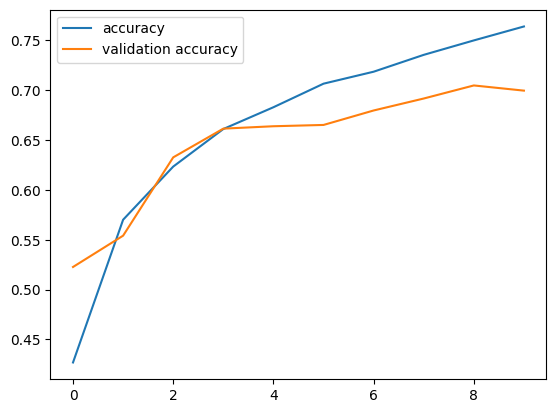

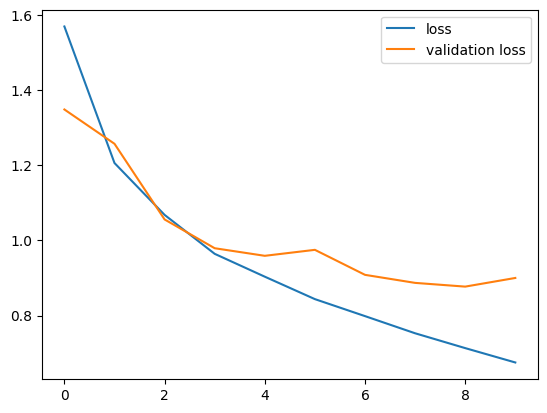

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "validation accuracy"])
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "validation loss"])
plt.show()

That was all from me, hope that it was clear and that you liked it, feel free to experiment a bit, next time we will start from here and use the custom training loop that we saw earlier to train a RL agent

Have funnnnnnnnn


![](https://media.tenor.com/lfDHEnYIUk4AAAAC/this-is-where-the-fun-begins-star-wars.gif)

## (Fun) Exercises

For the braves, I leave here some exercises (they should be pretty simple) to explore a bit and test your knowledge.

I'll give you the main structure of the code and you can just complete it, however, to achieve the same results, there are hundreds of ways, so if you find my scaffolding too cumbersome, or you think there is a better way (let alone possible errors), feel free to experiment... ad if you have questions, feel free to write me at [alberto.sinigaglia@phd.unipd.it](mailto:alberto.sinigaglia@phd.unipd.it)

### Batch Normalization

[Batch Normalization](https://arxiv.org/abs/1502.03167) is a very famous building block for neural networks, it is fundamental for big models, as it solves (tackles at least) a very famous problem in deep hierarchical models, called _internal covariate shift_... in poor words, when you change the parameters in the initial layers, their change is amplified by the change in the next layers, and when you get to the final layers, you have a completely different representation for the same image, thus the final layer has to be trained from scratch.

What BN do is pretty simple, and it's, as the name suggests, a normalization of each batch (intra network, so it's not just a preprocessing).
Given a batch of data of size $N$, BN applied to the $M$th layer, forward propagates the batch in the previous layers, obtaining the batch tensor $t$, and does the following:
$$
\mu = \frac{\sum_{i=0}^N t_i}{N} \\
\sigma^2 = \frac{\sum_{i=0}^N (t_i - \mu)^2}{N} \\
\hat{t} = \frac{t - \mu}{\sqrt{\sigma} + \epsilon}\\
t_\text{final} = \gamma \hat{t} + \beta
$$
in poor words, it first normalizes the batch, and then rescales and shift the tensor using $\beta, \gamma$, which are trained parameters, so that the network is free to learn where is best to have such distribution.

Let's create a Layer that does exactly that (actually, usually $\mu, \sigma$ are moving average, because you need a good statistic for this to work)

In [39]:
# we assume to be doing the normalization on the last dimension of the batch, so for images, we normalize per channel
class CustomBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, eps=1e-6, momentum=0.5, **kwargs):
    super().__init__(**kwargs)
    self.beta = None # final shift
    self.alpha = None # final rescale
    self.moving_std = None # moving average of the variance
    self.moving_mean = None # moving average of the mean
    self.eps = eps # epsilon, for stability
    self.momentum = momentum # momentum of the moving average
  def build(self, input_shape):
    # we initialize the parameters as we have seen until now, so there should be nothing new here
    self.alpha = self.add_weight("alpha", shape=(input_shape[-1],))
    self.beta = self.add_weight("beta", shape=(input_shape[-1],))
    self.moving_mean = self.add_weight("moving_mean", initializer=tf.zeros_initializer(), shape=(input_shape[-1],), trainable=False)
    self.moving_std = self.add_weight("moving_std", initializer=tf.zeros_initializer(), shape=(input_shape[-1],), trainable=False)
  def call(self, inputs, training, *args, **kwargs):
    # during training, we want to update the statistics
    if training:
      mean = tf.reduce_mean(inputs, axis=(0,1,2), name="batch_mean")
      std = tf.math.reduce_std(inputs, axis=(0,1,2), name="batch_std")
      self.moving_mean.assign(tf.add(self.moving_mean * self.momentum,  mean * (1 - self.momentum), name="new_moving_mean"))
      self.moving_std.assign(tf.add(self.moving_std * self.momentum, std * (1 - self.momentum), name="new_moving_std"))
    # reshape to allow tensor propagation
    mean = tf.reshape(self.moving_mean, (1, 1, -1))
    std = tf.reshape(self.moving_mean, (1, 1, -1))

    processed_inputs = tf.divide(tf.subtract(inputs, mean), tf.sqrt(std) + self.eps)
    return tf.add(tf.multiply(self.beta, processed_inputs), self.alpha)

In [40]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(CustomBatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [41]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6226 - accuracy: 0.4009 - val_loss: 1.4186 - val_accuracy: 0.4886
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2870 - accuracy: 0.5399 - val_loss: 1.2774 - val_accuracy: 0.5578
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1586 - accuracy: 0.5885 - val_loss: 1.1555 - val_accuracy: 0.5913
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0645 - accuracy: 0.6229 - val_loss: 1.0730 - val_accuracy: 0.6171
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9900 - accuracy: 0.6539 - val_loss: 1.0374 - val_accuracy: 0.6386
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9340 - accuracy: 0.6733 - val_loss: 1.0085 - val_accuracy: 0.6475
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8886 - accuracy: 0.6884 - val_loss: 0.9451 - val_accuracy:

### Residual connection

[Residual networks](https://arxiv.org/abs/1512.03385) are the other big famous super used building block for big networks. They solve an orthogonal problem to the one of BN, which is the vanishing gradient. What was observed before ResNet was that deep networks performed better than shallow networks, up to a certain point, and then performances worsened.

The problem is that given a N layer network, you can easily approximate it with a M layer network (M > N), by setting its first N layers with the same weights as the other network, and then the last M-N with an identity function.

However, layers are initialized so that they approximate the zero-function (weights close to 0), so the network has a hard time learning the identity.

To solve that, they just added a residual connection, which is "you some to your output, your input" (given that they have the same shape, otherwise you can concatenate it in some way):
$$
y_i = F(x_i) + x_i
$$
That's all... the intuition is that $F(x_i)$ is initialized with the 0-function, so if it's useless (like the last M-N layers in the previous example), you can just not learn anything in the last layers, and forward the information.

You can also think this as a "gradient descent" idea, where indeed GD has as update $x_i = x_i + F(x_i)$, where $F$ is just the gradient.


Let's code it!

In [44]:
class CustomResidualLayer(tf.keras.layers.Layer):
  # ffnn want's to be whatever stays between the input and the residual connection, which can be a single layer, or a whole model, makes no difference
  def __init__(self, ffnn, **kwargs):
    super().__init__(**kwargs)
    self.ffnn = tf.keras.models.Sequential(ffnn)

  def call(self, inputs, *args, **kwargs):
    return self.ffnn(inputs) + inputs

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(
  CustomResidualLayer([
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
  ])
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(
  CustomResidualLayer([
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
    layers.Conv2D(64, (3, 3), activation='relu', padding="SAME"),
  ])
)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [46]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 12s 8ms/step - loss: 1.5596 - accuracy: 0.4305 - val_loss: 1.2051 - val_accuracy: 0.5645
Epoch 2/10
1250/1250 [==============================] - 10s 8ms/step - loss: 1.0578 - accuracy: 0.6243 - val_loss: 1.0436 - val_accuracy: 0.6407
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8638 - accuracy: 0.6944 - val_loss: 0.9185 - val_accuracy: 0.6821
Epoch 4/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.7374 - accuracy: 0.7386 - val_loss: 0.9052 - val_accuracy: 0.6879
Epoch 5/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6305 - accuracy: 0.7784 - val_loss: 0.8914 - val_accuracy: 0.6962
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5323 - accuracy: 0.8100 - val_loss: 0.8707 - val_accuracy: 0.7194
Epoch 7/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.4468 - accuracy: 0.8410 - val_loss: 0.9020 - val_acc

### Dropout

[Dropout](https://arxiv.org/abs/1207.0580) is a very famous regularization method proposed from Hinton, that has a toooon of intuitions behind it... in very few words, it just randomly sets values to 0 with some probability (that you choose)

You can see this as a "regularization" since the network cannot rely always on the same information/neuron to predict, or you can see this as a cheap way of training an ensemble of neural networks.

To do so, we just do the following:
$$
m \sim Be(p) ^ {N} \\
y_i = F(x_i) \cdot m
$$

So it's pretty simple, we just need to create a layer that samples random binary masks form a Bernoulli distribution, and multiply.
At test time, we keep all the neurons on and we rescale the activation by $1-p$ (since you would have only $p$ active neurons, you "overstimulate the neuron if you activate all connections without rescaling the sum)

Let's do it.

![](https://media.tenor.com/JOJ1qSZon7UAAAAC/shia-labeouf-just-do-it.gif)

In [47]:
class CustomDropoutLayer(tf.keras.layers.Layer):
  def __init__(self, prob):
    super(CustomDropoutLayer, self).__init__()
    self.prob = prob

  def call(self, inputs, training=None):
    if training:
      # Generate a random mask with the same shape as the inputs
      mask = tf.random.uniform(shape=tf.shape(inputs), minval=0, maxval=1) >= self.prob
      masked_inputs = tf.math.divide_no_nan(inputs, 1.0 - self.prob) * tf.cast(mask, dtype=inputs.dtype)
      return masked_inputs
    return inputs

In [48]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(CustomDropoutLayer(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [49]:
model.compile(optimizer=tf.optimizers.legacy.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 6s 4ms/step - loss: 1.6507 - accuracy: 0.3960 - val_loss: 1.3713 - val_accuracy: 0.5153
Epoch 2/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.3112 - accuracy: 0.5302 - val_loss: 1.2581 - val_accuracy: 0.5659
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1729 - accuracy: 0.5839 - val_loss: 1.1183 - val_accuracy: 0.6036
Epoch 4/10
1250/1250 [==============================] - 4s 4ms/step - loss: 1.0915 - accuracy: 0.6155 - val_loss: 1.1820 - val_accuracy: 0.5838
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0225 - accuracy: 0.6400 - val_loss: 1.0764 - val_accuracy: 0.6274
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.9706 - accuracy: 0.6571 - val_loss: 0.9979 - val_accuracy: 0.6510
Epoch 7/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.9306 - accuracy: 0.6714 - val_loss: 0.9319 - val_accuracy:

### References to other possible fun projects

If you are interested in Deep Neural Networks, you can try to implement the following models:
 - Autoencoder
 - ResNet
 - Transformers
 - Variational Autoencoder
 - Generative Adverasarial Networks / Pix2Pix
 - Siamese Networks

For most of them there are already existing clean implementation from which you can take inspiration, I ranked them by difficulty, so maybe start from the initial ones and then move to the next